# Laboratorio 1
Luis Pedro Montenegro<br>
Carnet: 21699<br>
08/02/2026

## Detección de phishing en URL

*Phishing*<br>
Se basa en la ingeniería social (manipulación de emociones, aprovechamiento de atajos mentales y
sesgos cognitivos) para engañar a las víctimas y lograr que estas den información (normalmente
credenciales). Los atacantes envían mensajes haciéndose pasar por una entidad legitima a través de
correos y SMS bajo diversos “motivos urgentes” que requieren que la persona tome acción
inmediatamente, para lo cual incluyen un enlace que redirige al “sitio web” de la entidad.<br>

Estos sitios son literalmente copias de los sitios legítimos que intentan imitar, en muchas ocasiones
son muy difíciles de detectar. El usuario, temeroso de un evento negativo ingresa con sus credenciales,
las cuales son robadas y utilizadas por los atacantes para acceder a los verdaderos sitios legítimos
ocasionando pérdidas económicas (entre otros).<br>

Sin embargo, los dominios web no pueden copiarse al 100%, aunque existen técnicas avanzadas que
los hacen parecer similares al ojo humano. Además, las URLs de phishing poseen características que
las diferencian de las URLs legítimas, y que un modelo de ML puede utilizar para detectarlas y proteger
a los usuarios de estos ataques.

### Parte 1: Ingeniería de características
*Exploración de datos*

Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.

In [1]:
import pandas as pd
import os 


directory: str = os.getcwd()
df: pd.DataFrame = pd.read_csv(f"{directory}/dataset_pishing.csv")


In [2]:
df.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?

Sí está balanceado el conjunto de datos ya que tiene 5715 legítimos y el mismo número para phishing.

In [3]:
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

*Derivación de características*<br>
Revise los artículos proporcionados, especialmente en el análisis de las URLs. En base a su análisis
responda las siguientes preguntas:<br>
1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo
de vida del dominio, o las características de la página Web? <br>
El análisis de una URL tiene como ventaja que podemos detectar sitios maliciosos y de una vez bloquear su dirección IP para prevenir que se pueda acceder a 
otras páginas web dentro de la misma. También que se puede tomar cierta independencia del lenguaje en el cual está escrita la página. Y de igual forma que necesitaría menos características
para entrenar un modelo. 
2. ¿Qué características de una URL son más prometedoras para la detección de phishing?<br>
El protocolo que utiliza la url para la comunicación, la longitud de la url, cierto tipo de símbolos aparecidos dentro de la misma, por ejemplo: comas, slashes, guiones, etc. Tabmién si y emails presentes en las url y los subdominios, dominios y los supradominios. 

In [4]:
import re
from urllib.parse import urlparse

# Base functions
def get_protocol(url: str) -> str:
    protocol: str = url.split(':')[0]
    return protocol

def get_subdomain(url: str) -> str:
    parsed = urlparse(url)
    parts = parsed.hostname.split('.') if parsed.hostname else []
    return '.'.join(parts[:-2]) if len(parts) > 2 else 'missing'

def get_second_level_domain(url: str) -> str:
    parsed = urlparse(url)
    parts = parsed.hostname.split('.') if parsed.hostname else []
    return parts[-2] if len(parts) >= 2 else 'missing'


def get_top_level_domain(url: str) -> str:
    parsed = urlparse(url)
    parts = parsed.hostname.split('.') if parsed.hostname else []
    return parts[-1] if len(parts) >= 1 else 'missing'


def has_file(url: str) -> int:
    parsed = urlparse(url)
    if parsed.path:
        if parsed.path.split('/')[-1] != '':
            return 1
    return 0

def has_parameters(url: str) -> int:
    parsed = urlparse(url)
    if parsed.query != '':
        return 1
    return 0

def email_in_url(url: str) -> int:
    return int(bool(re.search(r'[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+', url)))

def has_ip(url: str) -> int:
    '''If the URL has an IP address'''
    return int(bool(re.search(r'https?://(?:\d{1,3}\.){3}\d{1,3}', url)))

def length_url(url: str) -> int:
    return len(url)

# helper
def count_symbol(url: str, symbol: str) -> int:
    if url:
        return url.count(symbol)
    return 0

def num_dots_url(url: str) -> int:
    return count_symbol(url=url, symbol='.')

def num_hyph_url(url: str) -> int:
    return count_symbol(url=url, symbol="-")

def num_underline_url(url: str) -> int:
    return count_symbol(url=url, symbol="_")

def num_slash_url(url: str) -> int:
    return count_symbol(url=url, symbol="/")

def at_sign_url(url: str) -> int:
    return count_symbol(url=url, symbol="@")

def num_plus_url(url: str) -> int:
    return count_symbol(url=url, symbol="+")

def num_and_symbols(url: str) -> int:
    return count_symbol(url=url, symbol="&")

def num_equal_url(url: str) -> int:
    return count_symbol(url=url, symbol="=")

def num_question_url(url: str) -> int:
    return count_symbol(url=url, symbol="?")

In [5]:
import math
from collections import Counter

def count_dict(url: str) -> dict:
    counter = Counter(url)
    return dict(counter)


def shannon_entropy(url: str) -> float:
    entropy: float = 0.0
    length: int = len(url)
    frequencies: dict = count_dict(url)
    for _, freq in frequencies.items():

        probability: float = freq/length
        if probability == 0:
            continue
        entropy += probability * math.log2(1/probability)
    return entropy

def relative_entropy(url: str) -> float:
    entropy: float = 0.0
    frequencies: dict = count_dict(url)
    for letter, freq in frequencies.items():
        probability: float = freq
        if probability == 0:
            continue
        q_prob: float = Q.get(letter, 1e-6)
        entropy += probability * math.log(probability / q_prob)
    return entropy

In [6]:
df['protocol'] = df['url'].apply(get_protocol) 
df['subdomain'] = df['url'].apply(get_subdomain)
df['second_domain'] = df['url'].apply(get_second_level_domain)
df['top_domain'] = df['url'].apply(get_top_level_domain)
df['file_name'] = df['url'].apply(has_file)
df['parameters'] = df['url'].apply(has_parameters)
df['email'] = df['url'].apply(email_in_url)
df['ip'] = df['url'].apply(has_ip)
df['length'] = df['url'].apply(length_url)
df['num_dots'] = df['url'].apply(num_dots_url)
df['num_hyph'] = df['url'].apply(num_hyph_url)
df['num_underline'] = df['url'].apply(num_underline_url)
df['num_slash'] = df['url'].apply(num_slash_url)
df['num_at_sign'] = df['url'].apply(at_sign_url)
df['num_plus'] = df['url'].apply(num_plus_url)
df['num_and'] = df['url'].apply(num_and_symbols)
df['num_equal'] = df['url'].apply(num_equal_url)
df['num_question'] = df['url'].apply(num_question_url)

*Preprocesamiento*<br>

Modificar la variable categórica *status* a una variable binaria. <br>
```
legitimate -> 0
phishing -> 1
```

In [7]:
df['status'] = df['status'].map({'legitimate' : 0, 'phishing' : 1})
df.head(5)

,url,status,protocol,subdomain,second_domain,top_domain,file_name,parameters,email,ip,length,num_dots,num_hyph,num_underline,num_slash,num_at_sign,num_plus,num_and,num_equal,num_question
0,http://www.crestonwood.com/router.php,0,http,www,crestonwood,com,1,0,0,0,37,3,0,0,3,0,0,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,1,http,missing,shadetreetechnology,com,1,0,0,0,77,1,0,0,5,0,0,0,0,0
2,https://support-appleld.com.secureupdate.duila...,1,https,support-appleld.com.secureupdate,duilawyeryork,com,0,1,0,0,126,4,1,2,5,0,0,2,3,1
3,http://rgipt.ac.in,0,http,rgipt,ac,in,0,0,0,0,18,2,0,0,2,0,0,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0,http,www,iracing,com,0,0,0,0,55,2,2,0,5,0,0,0,0,0


In [8]:
df = df.drop(columns=['url'])

In [9]:
# one-hot encoding protocol
df = pd.get_dummies(df, columns=['protocol'], prefix='protocol', dtype=int)
df.head(5)

,status,subdomain,second_domain,top_domain,file_name,parameters,email,ip,length,num_dots,num_hyph,num_underline,num_slash,num_at_sign,num_plus,num_and,num_equal,num_question,protocol_http,protocol_https
0,0,www,crestonwood,com,1,0,0,0,37,3,0,0,3,0,0,0,0,0,1,0
1,1,missing,shadetreetechnology,com,1,0,0,0,77,1,0,0,5,0,0,0,0,0,1,0
2,1,support-appleld.com.secureupdate,duilawyeryork,com,0,1,0,0,126,4,1,2,5,0,0,2,3,1,0,1
3,0,rgipt,ac,in,0,0,0,0,18,2,0,0,2,0,0,0,0,0,1,0
4,0,www,iracing,com,0,0,0,0,55,2,2,0,5,0,0,0,0,0,1,0


In [10]:
from sklearn.preprocessing import LabelEncoder

for col in ['subdomain', 'second_domain', 'top_domain']:
    le = LabelEncoder()
    df[col + '_label'] = le.fit_transform(df[col].astype(str))

df.head(5)

,status,subdomain,second_domain,top_domain,file_name,parameters,email,ip,length,num_dots,...,num_at_sign,num_plus,num_and,num_equal,num_question,protocol_http,protocol_https,subdomain_label,second_domain_label,top_domain_label
0,0,www,crestonwood,com,1,0,0,0,37,3,...,0,0,0,0,0,1,0,2602,1254,110
1,1,missing,shadetreetechnology,com,1,0,0,0,77,1,...,0,0,0,0,0,1,0,1535,4604,110
2,1,support-appleld.com.secureupdate,duilawyeryork,com,0,1,0,0,126,4,...,0,0,2,3,1,0,1,2244,1542,110
3,0,rgipt,ac,in,0,0,0,0,18,2,...,0,0,0,0,0,1,0,1942,151,153
4,0,www,iracing,com,0,0,0,0,55,2,...,0,0,0,0,0,1,0,2602,2631,110


In [11]:
df = df.drop(columns=['subdomain', 'second_domain', 'top_domain'])
df.head(5)

,status,file_name,parameters,email,ip,length,num_dots,num_hyph,num_underline,num_slash,num_at_sign,num_plus,num_and,num_equal,num_question,protocol_http,protocol_https,subdomain_label,second_domain_label,top_domain_label
0,0,1,0,0,0,37,3,0,0,3,0,0,0,0,0,1,0,2602,1254,110
1,1,1,0,0,0,77,1,0,0,5,0,0,0,0,0,1,0,1535,4604,110
2,1,0,1,0,0,126,4,1,2,5,0,0,2,3,1,0,1,2244,1542,110
3,0,0,0,0,0,18,2,0,0,2,0,0,0,0,0,1,0,1942,151,153
4,0,0,0,0,0,55,2,2,0,5,0,0,0,0,0,1,0,2602,2631,110


*Selección de características*

En la exploración de datos, determine las columnas que son constantes, o que no tienen una varianza
alta con la columna status. Elimine las características repetidas o irrelevantes para la clasificación de
un sitio de phishing. Verifique que no posee observaciones repetidas. Apóyese con la visualización de
características y correlación para seleccionar las características más importantes para clasificar una
URL legítima de una URL de phishing. <br>

¿Qué columnas o características fueron seleccionadas y por qué?<br>
Las columnas fueron las siguientes:
- file_name: porque indica si hay archivos
- parameters: porque indica si hay parámetros en el url, usualmente asociados a phishing.
- email: es un pequeño indicio que puede haber phishing
- ip: igual que email
- length: la longitud puede estar relacionada a phishing
- num_dots: el número de puntos puede indicar phishing
- num_hyph: el número de hyphens puede indicar no phishing
- num_slash: puede indicar no phishing
- num_at: las arrobas pueden indicar phising
- num_plus: puede o no indicar phishing, capaz se descarta.
- num_and: puede indicar phishing
- num_equal: puede indicar phishing
- num_question: puede o no indicar, capaz se descarta
- protocol_http: puede o no indicar phishing, capaz se descarta
- protocol_https: puede o no indicar phishing, capaz se descarta
- subdomain_label: puede indicar phishing
- second_domain: puede indicar no phishing
- top_domain: puede indicar phishing

In [12]:
df.groupby('status').var()

,file_name,parameters,email,ip,length,num_dots,num_hyph,num_underline,num_slash,num_at_sign,num_plus,num_and,num_equal,num_question,protocol_http,protocol_https,subdomain_label,second_domain_label,top_domain_label
status,,,,,,,,,,,,,,,,,,,
0,0.249473,0.032310,0.000000,0.000000,776.330142,0.430304,5.873357,1.034773,1.709267,0.000000,0.071797,0.145988,0.222138,0.033149,0.247015,0.247015,448777.411145,3.310067e+06,2320.331066
1,0.243746,0.180729,0.039597,0.016857,4961.156066,3.161366,2.751953,1.352733,4.961161,0.047377,0.009438,1.164074,1.662730,0.209516,0.222203,0.222203,600976.547038,2.945576e+06,2572.685958


### Parte 2: Implementación

*Separación de datos*
- Datos de entrenamiento: 55%
- Datos de validación: 15%
- Datos de prueba: 30%
- Almacene cada dataset como un archivo .csv

In [13]:
from sklearn.model_selection import train_test_split

train, temp = train_test_split(df, test_size=0.45, random_state=42)

val, test = train_test_split(temp, test_size=0.66, random_state=42)

In [14]:
train.to_csv(f'{directory}/train.csv', index=False)
val.to_csv(f'{directory}/val.csv', index=False)
test.to_csv(f'{directory}/test.csv', index=False)

*Implementación*
Implemente dos modelos de Machine Learning (a su discreción) para la clasificación de phishing.
Muestre y explique los valores obtenidos de las siguientes métricas para los datos de validación y
pruebas, para cada modelo, en base al contexto del problema (detección de Pishing).
- Matriz de confusión
- Precision
- Recall
- Curva ROC
- AUC

In [15]:
X_train = train.drop(columns='status')
y_train = train['status']

X_val = val.drop(columns='status')
y_val = val['status']

X_test = test.drop(columns='status')
y_test = test['status']

In [16]:
from sklearn.ensemble import RandomForestClassifier

rand_forest_classifier = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rand_forest_classifier.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

In [19]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(max_depth=6, random_state=42)
tree_classifier.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

Random Forest results: 

              precision    recall  f1-score   support

           0     0.8474    0.7925    0.8190      1696
           1     0.8055    0.8576    0.8308      1700

    accuracy                         0.8251      3396
   macro avg     0.8265    0.8250    0.8249      3396
weighted avg     0.8264    0.8251    0.8249      3396

ROC AUC Score 0.9074


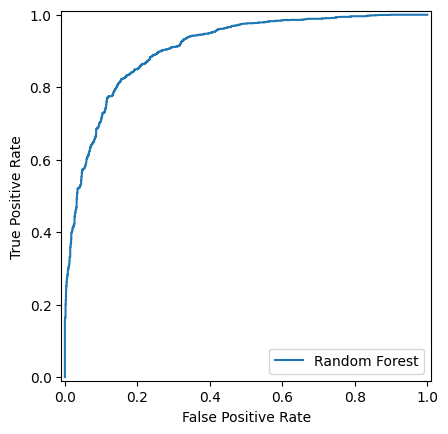

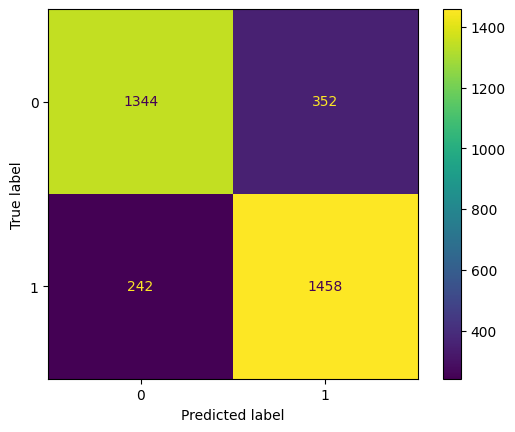

Decision Tree results: 

              precision    recall  f1-score   support

           0     0.8398    0.7913    0.8148      1696
           1     0.8031    0.8494    0.8256      1700

    accuracy                         0.8204      3396
   macro avg     0.8215    0.8203    0.8202      3396
weighted avg     0.8214    0.8204    0.8202      3396

ROC AUC Score 0.8829


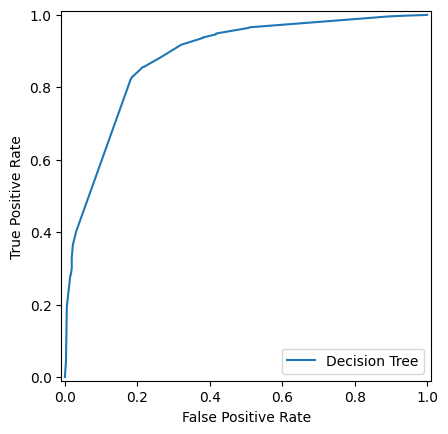

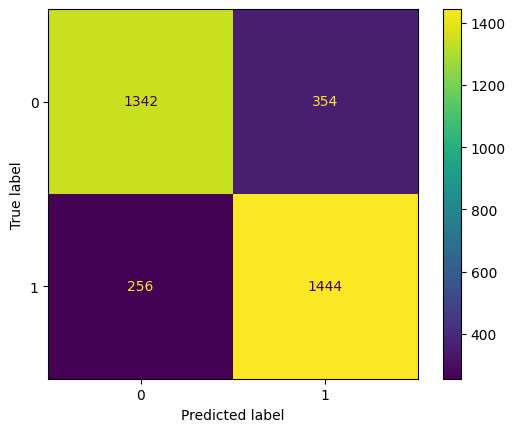

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
import matplotlib.pyplot as plt
models = {
    "Random Forest": rand_forest_classifier,
    "Decision Tree": tree_classifier
}

for name, model in models.items():
    print(f"{name} results: \n")

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Precission, Recall, F1-Score
    print(classification_report(y_test, y_pred, digits=4))


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score {auc:.4f}")

    RocCurveDisplay(fpr=fpr, tpr=tpr, name=name).plot() # type: ignore 
    ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_).plot()
    plt.show()

*Discusión*

4. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?<br>

El impacto de clasificar un sitio web como phishing implica que ese sitio web posiblemente quede removido junto con todas sus páginas. Afectando al dueño del sitio.

5. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?<br>

Presenta el riesgo que gente caiga dentro de ese sitio web pensando que es legítimo cuando no lo es. Poniendo un riesgo latente en la internet.

6. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares
de clasificación de phishing?<br>

La métrica que elegiría es la matriz de confusión. Ya que esta nos indica los aciertos y desaciertos que tuvo nuestro modelo y la cantidad de estos mismos.

7. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?<br>

Dentro de los modelos de RandomForest y DecisionTree hubo casi nula diferenciación. Posiblemente porque RandomForest está basado en el DecisionTree. Sin embargo,
el DecisionTree tuvo menos ligeramente menos errores a la hora de clasificar falsos positivos y falsos negativos. Por lo que considero que fue el mejor modelo de los dos. 

8. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes
ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails,
un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y
cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué
propone para reducir la cantidad de falsas alarmas?<br>

La cantidad de casos que generaría son 8610 casos. De estas habría aproximadamente unos 6432 casos positivos y 2178 casos negativos. 
Para el base rate propuesto, vemos que tuvo una disminución de un casi 10%, lo cual lo deja con 0.75 de precisión teniendo antes un 85%. Esto quiere decir
que el modelo no funcionaría en la vida real como se especula. Por ello, para reducir la cantidad de falsas alarmas se puede quizás escojer otro modelo en el peor de los casos.
Pero en este caso quizá pueda servir cambiar un poco en qué características nos estamos enfocando a la hora de entrenar el modelo para así mejorar su precisión. Sin embargo, dentro de la predicción aún persiste el hecho de que baje su precisión por lo que no es garantizado que esto ayude.


In [25]:
specificity: float = 0.95
total_phishing: int = 50000
phishing_rate: float = 0.15
rf_recall: float = 0.8576
real_phishing: float = total_phishing * phishing_rate
rf_precission: float = 0.8031 
base_rate: float = real_phishing / total_phishing

FPR = 1 - specificity
FNR = 1 - rf_recall
P = total_phishing * base_rate

TP = (1 - FNR) * P
FP = FPR * (total_phishing - TP)

predicted_total = TP + FP
pred_precision = TP / predicted_total

print(f"Predicted cases: {predicted_total:.0f}\nPrecision: {pred_precision:.2f}")
print(f"True Positives: {TP:.0f}\nFalse Positives: {FP:.0f}")

Predicted cases: 8610
Precision: 0.75
True Positives: 6432
False Positives: 2178
